In [10]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.io import fits

import HELP
gmod = HELP.get_model
makmod = HELP.make_spotmodel

import getMag
gMag = getMag.getMag

import getMag_hires
gMag_hires = getMag_hires.getMag_hires

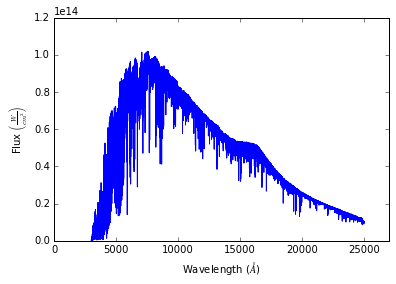

In [11]:
PhTemp = '4000'
SpTemp = '2300'
FillFactor = .2
wavelength,tot_flux,PhTemp,SpTemp,FillFactor = makmod(PhTemp,SpTemp,FillFactor) #Creates spectrum for desired temps and fill-factor

plt.plot(wavelength,tot_flux)
plt.xlim(0,27000)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel(r'Flux $\left(\frac{W}{cm^2}\right)$')

[('Ks', 21589.999999999996, -76.685349359150692), ('H', 16620.0, -76.510571638547788), ('J', 12350.000000000002, -75.795624262583971), ('U', 3650.0, -70.703948143373708), ('B', 4450.0, -71.949261504832577), ('V', 5510.0, -73.187399075029745), ('R', 6580.0, -73.938333303893884), ('I', 8060.000000000001, -74.720165044831361)]


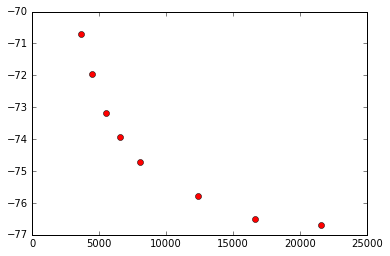

In [13]:
#initialize arrays of filter names
bands = np.array(['Ks','H','J','U','B','V','R','I'])
bands_hires = ['Ks','H','J']


#fill up a 3D array 'syn_phot' with: filter name, center point, magnitude
syn_phot = []
for i in range(len(bands)):
    x = gMag(bands[i],wavelength,tot_flux,'angstrom') #x returns three values; band, center, mag
    syn_phot.append(x)


print(syn_phot)
centers = [i[1] for i in syn_phot]
magnitudes = [i[2] for i in syn_phot]
plt.plot(centers,magnitudes,'ro')